### 1. 소개

타이타닉 생존률 회귀분석은 타이타닉 호에 탑승한 승객들의 생존 여부를 예측하는 데에 초점을 맞추고 있습니다.  
이 데이터셋은 각 승객 여러 특성들(성별, 나이, 객실 등급 등)과 생존 여부를 포함하고 있습니다.

In [1]:
import pandas as pd
import seaborn as sns

titanic = sns.load_dataset('titanic')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### 2. 데이터 전처리

각 특성별 생존율과의 상관관계를 분석했습니다.  
데이터의 일부 특성은 결측값을 포함하고 있어 해당 특성의 평균값으로 대체했습니다.  
연속형 특성인 나이를 사분위수에 따라 구간으로 변환하였습니다.  
범주형 특성인 성별을 더미 변수로 변환했습니다.

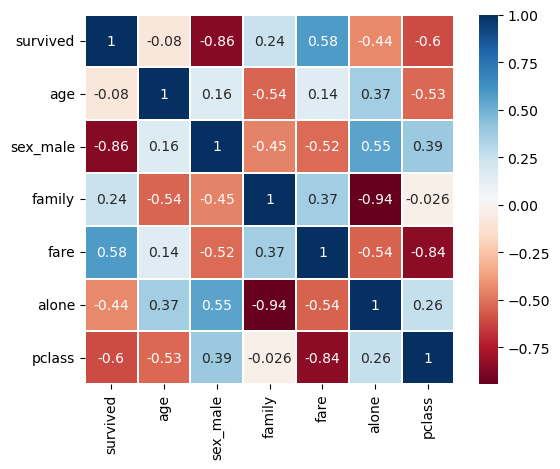

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

titanic = sns.load_dataset('titanic')

titanic = pd.get_dummies(titanic, columns=['sex'], drop_first=True)
titanic['family'] = titanic['sibsp'] + titanic['parch'] + 1
selected_columns = ['survived', 'age', 'sex_male', 'family', 'fare', 'alone', 'pclass']
titanic = titanic[selected_columns].dropna()


#상관 분석을 위한 상한 계수 구하고 저장하기
#피어슨상관계수를 적용하여상관계수를구함
titanic_corr = titanic.corr(method = 'pearson')

colormap = plt.cm.RdBu
sns.heatmap(titanic_corr.astype(float).corr(), linewidths = 0.1, vmax= 1.0, square = True, cmap = colormap, linecolor = 'white', annot = True,annot_kws = {"size": 10})
plt.show()

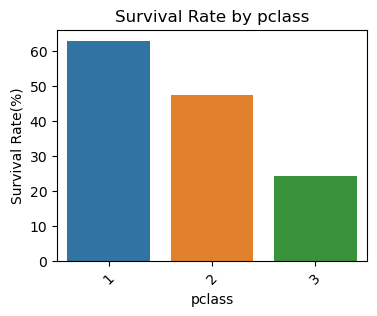

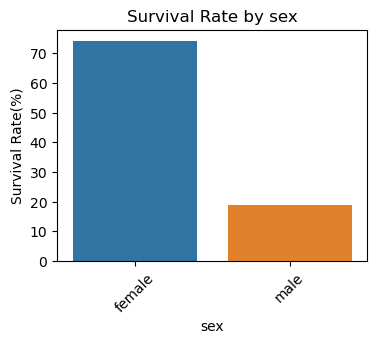

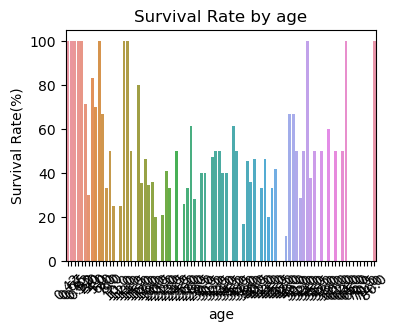

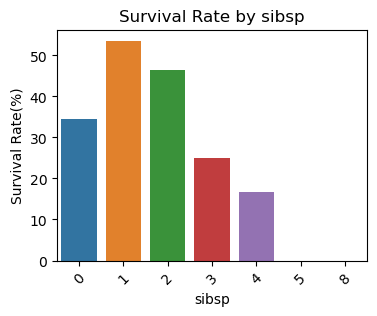

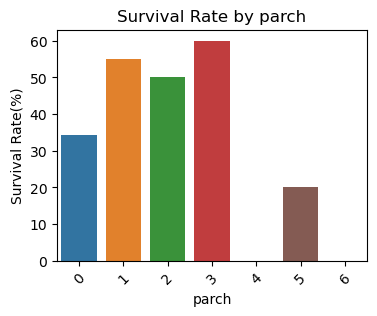

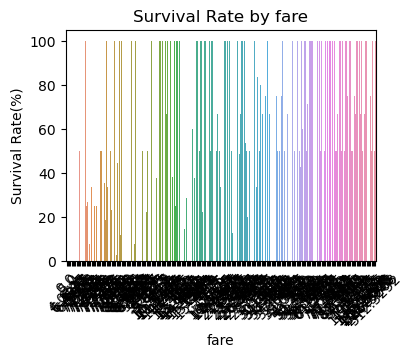

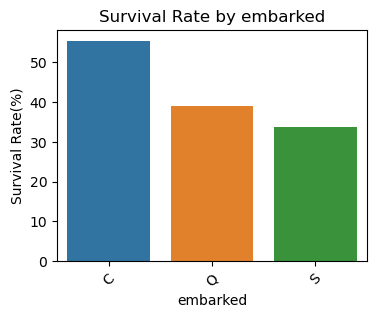

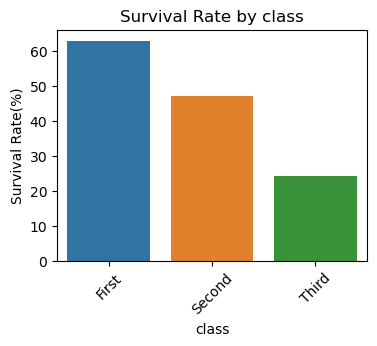

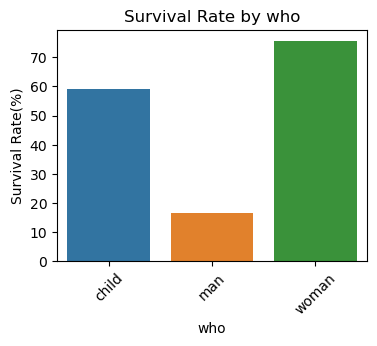

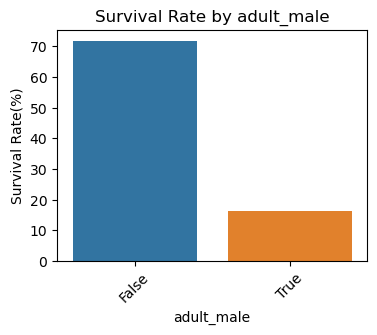

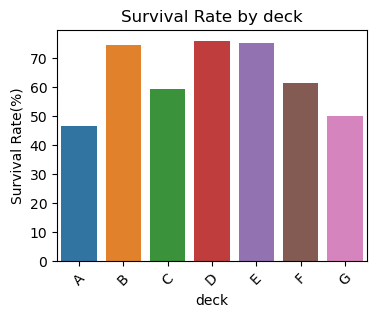

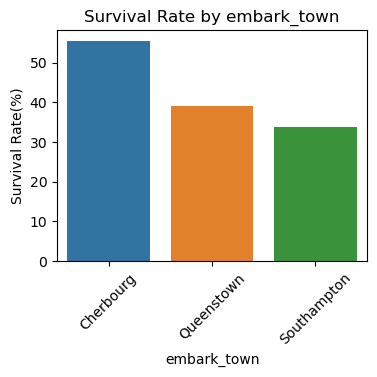

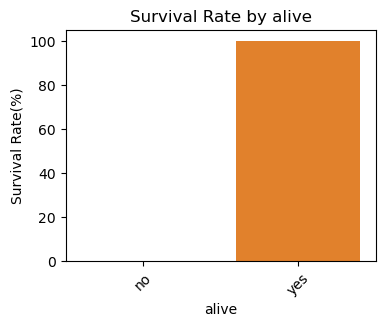

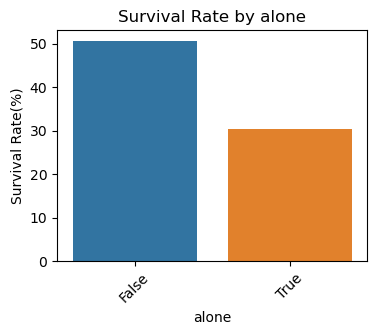

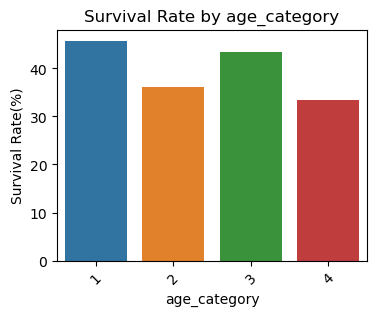

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

titanic = sns.load_dataset('titanic')

# 사분위수 계산
q1 = titanic['age'].quantile(0.25)
q2 = titanic['age'].quantile(0.5)
q3 = titanic['age'].quantile(0.75)

# 나이를 구간으로 변환하는 함수 정의
def categorize_age(age):
    if age <= q1:
        return 1
    elif q1 < age <= q2:
        return 2
    elif q2 < age <= q3:
        return 3
    else:
        return 4

# 나이를 범주화하여 새로운 열 추가
titanic['age_category'] = titanic['age'].apply(categorize_age)

# Define a function to calculate survival rate for each category in a column
def survival_rate_by_column(df, column):
    return df.groupby(column)['survived'].mean()*100

# Get the list of column names excluding 'survived'
columns = [col for col in titanic.columns if col != 'survived']

# Plot survival rate for each column
for col in columns:
    survival_rates = survival_rate_by_column(titanic, col)
    plt.figure(figsize=(4, 3))
    sns.barplot(x=survival_rates.index, y=survival_rates.values)
    plt.title(f'Survival Rate by {col}')
    plt.xlabel(col)
    plt.ylabel('Survival Rate(%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

### 3. 모델링

여러가지 분석모델을 비교했습니다.  
사용한 모델은 랜덤 포레스트와 그래디언트 부스팅 회귀분석을 앙상블한 모델입니다.  
랜덤 포레스트와 그래디언트 부스팅 모델은 각각 100개의 의사결정 트리를 사용하여 훈련되었습니다.  

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

titanic = sns.load_dataset("titanic")

# 사분위수 계산
q1 = titanic['age'].quantile(0.25)
q2 = titanic['age'].quantile(0.5)
q3 = titanic['age'].quantile(0.75)

# 나이를 구간으로 변환하는 함수 정의
def categorize_age(age):
    if age <= q1:
        return 1
    elif q1 < age <= q2:
        return 2
    elif q2 < age <= q3:
        return 3
    else:
        return 4

# 나이를 범주화하여 새로운 열 추가
titanic['age_category'] = titanic['age'].apply(categorize_age)

# Preprocess the data (handle missing values, create dummy variables, etc.)
# For simplicity, let's focus on a few relevant columns
selected_columns = ['survived', 'sex', 'age_category', 'pclass', 'alone']
titanic = titanic[selected_columns].dropna()

# Create dummy variables for the 'sex' column
titanic = pd.get_dummies(titanic, columns=['sex'], drop_first=True)

# Define the independent variables (X) and the dependent variable (y)
X = titanic[['sex_male', 'age_category', 'pclass', 'alone']]
y = titanic['survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression()

#DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

#RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.8212
RandomForestClassifier 정확도:0.8268
LogisticRegression 정확도: 0.7877


### 4. 모델 평가

모델의 성능은 정확도(Accuracy)와 혼동 행렬(Confusion Matrix)을 통해 평가되었습니다.  
또한, 교차 검증(Cross Validation)을 통해 모델의 일반화 성능을 평가하였습니다.  

Ensemble Model 성능:
Accuracy: 0.83

Confusion Matrix:
[[99  6]
 [25 49]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       105
           1       0.89      0.66      0.76        74

    accuracy                           0.83       179
   macro avg       0.84      0.80      0.81       179
weighted avg       0.84      0.83      0.82       179



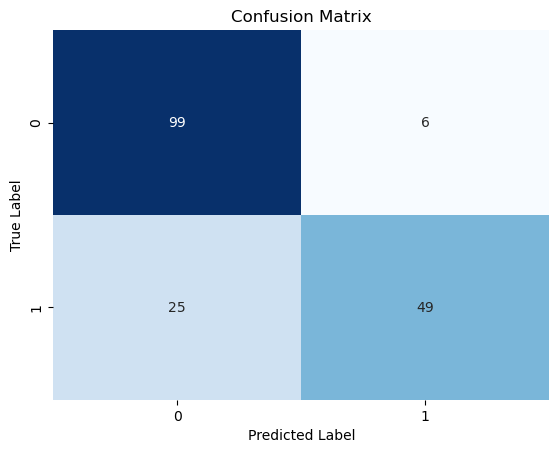

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the Titanic dataset from Seaborn
titanic = sns.load_dataset("titanic")

# 사분위수 계산
q1 = titanic['age'].quantile(0.25)
q2 = titanic['age'].quantile(0.5)
q3 = titanic['age'].quantile(0.75)

# 나이를 구간으로 변환하는 함수 정의
def categorize_age(age):
    if age <= q1:
        return 1
    elif q1 < age <= q2:
        return 2
    elif q2 < age <= q3:
        return 3
    else:
        return 4

# 나이를 범주화하여 새로운 열 추가
titanic['age_category'] = titanic['age'].apply(categorize_age)

# Preprocess the data (handle missing values, create dummy variables, etc.)
# For simplicity, let's focus on a few relevant columns
selected_columns = ['survived', 'sex', 'age_category', 'pclass', 'alone']
titanic = titanic[selected_columns].dropna()


# Create dummy variables for the 'sex' column
titanic = pd.get_dummies(titanic, columns=['sex'], drop_first=True)

# Define the independent variables (X) and the dependent variable (y)
X = titanic[['sex_male', 'age_category', 'pclass', 'alone']]
y = titanic['survived']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Gradient Boosting 모델 생성
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Random Forest 모델 훈련
rf_model.fit(X_train, y_train)

# Gradient Boosting 모델 훈련
gb_model.fit(X_train, y_train)

# Random Forest 모델 예측
rf_pred = rf_model.predict(X_test)

# Gradient Boosting 모델 예측
gb_pred = gb_model.predict(X_test)

# 앙상블 모델 예측
ensemble_pred = (rf_pred + gb_pred) // 2  # 간단한 투표 방식

# 앙상블 모델 성능 평가
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_pred)

# 결과 출력
print("Ensemble Model 성능:")
print(f"Accuracy: {ensemble_accuracy:.2f}")
print("\nConfusion Matrix:")
print(ensemble_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, ensemble_pred))

# Plot the confusion matrix
sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 5. 결과

랜덤 포레스트와 그래디언트 부스팅 모델은 각각 약 80% 이상의 정확도를 보였습니다.  
모델의 혼동 행렬을 통해 생존과 사망을 정확하게 예측한 비율을 확인할 수 있었습니다.  
교차 검증 결과를 통해 모델의 일반화 성능을 확인하였으며, 이를 통해 모델이 새로운 데이터에 대해서도 잘 작동할 것으로 예상됩니다.  

### 6. 새로운 데이터 예측

tkinter로 타이타닉 생존율 예측 gui를 만들었습니다.  
성별, 나이, 객실등급, 동승자를 입력받아 생존율을 예측합니다.

In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns
import pandas as pd

# Load the Titanic dataset from Seaborn
titanic = sns.load_dataset("titanic")

# 사분위수 계산
q1 = titanic['age'].quantile(0.25)
q2 = titanic['age'].quantile(0.5)
q3 = titanic['age'].quantile(0.75)

# 나이를 구간으로 변환하는 함수 정의
def categorize_age(age):
    if age <= q1:
        return 1
    elif q1 < age <= q2:
        return 2
    elif q2 < age <= q3:
        return 3
    else:
        return 4
    
    
def learning_titanic(titanic):
    # 나이를 범주화하여 새로운 열 추가
    titanic['age_category'] = titanic['age'].apply(categorize_age)

    # Preprocess the data (handle missing values, create dummy variables, etc.)
    # For simplicity, let's focus on a few relevant columns
    selected_columns = ['survived', 'sex', 'age_category', 'pclass', 'alone']
    titanic = titanic[selected_columns].dropna()


    # Create dummy variables for the 'sex' column
    titanic = pd.get_dummies(titanic, columns=['sex'], drop_first=True)

    # Define the independent variables (X) and the dependent variable (y)
    X = titanic[['sex_male', 'age_category', 'pclass', 'alone']]
    y = titanic['survived']

    # Random Forest 모델 생성
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Gradient Boosting 모델 생성
    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

    # Random Forest 모델 훈련
    rf_model.fit(X, y)

    # Gradient Boosting 모델 훈련
    gb_model.fit(X, y)
    
    return rf_model, gb_model


def predict_titanic(data):
    # Random Forest 모델 예측
    rf_pred_prob = rf_model.predict_proba(data)[:, 1]

    # Gradient Boosting 모델 예측
    gb_pred_prob = gb_model.predict_proba(data)[:, 1]

    # 앙상블 모델 예측
    ensemble_pred_prob = (rf_pred_prob + gb_pred_prob) / 2  # 간단한 투표 방식

    return ensemble_pred_prob[0]

In [16]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox

class Prediction():
    def __init__(self):
        self.rf_model, self.gb_model = learning_titanic(titanic)
        self.run()
    
    def run(self):
        # Tk 객체 생성
        self.root = tk.Tk()
        self.root.title("Prediction")
        self.root.geometry("300x250")
        self.root.resizable(0,0)

        # 레이블 생성
        self.label = tk.Label(self.root, text="타이타닉 생존율 예측")
        self.label.grid(row=0, column=0, columnspan=2, padx=10, pady=10)

        self.gen_strs = tk.StringVar() #변수선언
        self.pclass_strs = tk.StringVar()


        self.gen_label = tk.Label(self.root, text="성별")
        self.gen_label.grid(row=1, column=0, padx=10, pady=5, sticky="e")
        self.Combx1 = ttk.Combobox(textvariable=self.gen_strs) #콤보박스 선언
        self.Combx1['value'] = ('남자','여자') #콤보박스 요소 삽입
        self.Combx1.current(0) #0번째로 콤보박스 초기화
        self.Combx1.grid(row=1,column=1, padx=10, pady=5, sticky="w") #콤보박스 배치


        self.age_lable = tk.Label(self.root, text="나이")
        self.age_lable.grid(row=2, column=0, padx=10, pady=5, sticky="e")
        self.age_entry = tk.Entry(self.root, width=23)
        self.age_entry.grid(row=2, column=1, padx=10, pady=5, sticky="w")

        self.pclass_label = tk.Label(self.root, text="객실등급")
        self.pclass_label.grid(row=3, column=0, padx=10, pady=5, sticky="e")
        self.Combx2 = ttk.Combobox(textvariable=self.pclass_strs)
        self.Combx2['value'] = ('1','2','3')
        self.Combx2.current(0)
        self.Combx2.grid(row=3,column=1, padx=10, pady=5, sticky="w")


        self.alone_label = tk.Label(self.root, text="동승자")
        self.alone_label.grid(row=4, column=0, padx=10, pady=5, sticky="e")
        self.alone_entry = tk.Entry(self.root, width=23)
        self.alone_entry.grid(row=4, column=1, padx=10, pady=5, sticky="w")

        self.result_label = tk.Label(self.root, text="")
        self.result_label.grid(row=5, column=0, columnspan=2, padx=10, pady=10)

        # 버튼 생성
        self.predict_button = tk.Button(self.root, text="Predict", command=self.predict)
        self.predict_button.grid(row=6, column=1, padx=10, pady=10, sticky="e")

        # 이벤트 루프 시작
        self.root.mainloop()
        
    
    def get_data(self):
        gen = self.gen_strs.get()
        if gen == "남자" :
            gen = [True]
        else :
            gen = [False]

        try:
            age = int(self.age_entry.get())
        except:
            messagebox.showwarning("Warning", "숫자를 입력하세요.")
        age = [categorize_age(age)]

        pclass = [int(self.pclass_strs.get())]

        try:
            alone = int(self.alone_entry.get())
        except:
            messagebox.showwarning("Warning", "숫자를 입력하세요.")
        check_alone = lambda x : True if x == 0 else False
        alone = [check_alone(alone)]

        data = {
            'sex_male': gen,
            'age_category': age,
            'pclass': pclass,
            'alone': alone
        }
        df = pd.DataFrame(data)

        return df
        
    # 예측 버튼 함수
    def predict(self):
        data = self.get_data()
        result = predict_titanic(data)
        self.result_label.config(text="생존율 : {:.2f}%".format(result*100))

In [18]:
prediction = Prediction()

![타이타닉 생존율 예측](Prediction.png)

### 6. 결론

이 분석을 통해 생존률을 예측하는 데에 랜덤 포레스트와 그래디언트 부스팅 모델이 효과적임을 확인할 수 있었습니다.  
더 많은 특성을 고려하거나 모델 파라미터를 조정함으로써 모델의 성능을 더욱 향상시킬 수 있을 것으로 기대됩니다.  